# 04. Loading from and Saving to Disk

**Note**: the appearance of this notebook will depend on the environment and screen size you're using. If the tables are being clipped or the figures look off, consider trying Google Colab or Github via the buttons below. This notebook was created in VSCode, and will likely look best locally.

<a target="_blank" href="https://colab.research.google.com/github/ioverho/prob_conf_mat/blob/main/documentation/Getting%20Started/04_loading_and_saving_to_disk.ipynb">
  <img alt="Static Badge" src="https://img.shields.io/badge/Run_in_Colab-_?style=for-the-badge&logo=googlecolab&labelColor=gray&color=1082c3&link=https%3A%2F%2Fgithub.com%2Fioverho%2Fprob_conf_mat%2Fblob%2Fmain%2Fdocumentation%2FGetting%2520Started%2F04_loading_and_saving_to_disk.ipynb">
</a>
<a target="_blank" href="https://github.com/ioverho/prob_conf_mat/blob/main/documentation/Getting%20Started/04_loading_and_saving_to_disk.ipynb">
  <img alt="Static Badge" src="https://img.shields.io/badge/View_in_Github-_?style=for-the-badge&logo=github&labelColor=gray&color=1082c3&link=https%3A%2F%2Fgithub.com%2Fioverho%2Fprob_conf_mat%2Fblob%2Fmain%2Fdocumentation%2FGetting%2520Started%2F04_loading_and_saving_to_disk.ipynb">
</a>

## Setup

So far, we've created all of the confusion matrices on the fly, directly in the notebook. This is not really realistic; most of the time a confusion matrix is created in some validation loop in a different environment than the one we'll be using to do analysis on the results. In this notebook, we'll load in some confusion matrices from the filesystem, and we'll save the report configuration to the filesystem for easy reproducibility.

As an example, let's say we conducted an experiment with the [MNIST digits dataset](https://en.wikipedia.org/wiki/MNIST_database), where we compare the performance of an MLP against that of an SVM. We performed 5 fold cross-validation, and save each produced test split confusion matrix as '{$MODEL}_{$FOLD}.csv' files.

In [1]:
# Shows the contents of the './mnist_digits' directory
%ls ./mnist_digits


mlp_0.csv  mlp_2.csv  mlp_4.csv  svm_1.csv  svm_3.csv
mlp_1.csv  mlp_3.csv  svm_0.csv  svm_2.csv  svm_4.csv


First, let's configure a Study, where we analyze the models based on their average accuracy, F1 (binary, micro and macro aggregated) and MCC scores.

In [2]:
import prob_conf_mat as pcm

study = pcm.Study(seed=0, num_samples=10000, ci_probability=0.95)

study.add_metric(metric="acc", aggregation="fe_gaussian")
study.add_metric(metric="f1", aggregation="fe_gaussian")
study.add_metric(metric="f1@weighted", aggregation="fe_gaussian")
study.add_metric(metric="f1@macro", aggregation="fe_gaussian")
study.add_metric(metric="mcc", aggregation="beta")


The Study object requires us to pass in a valid confusion matrix for each experiment. Luckily, some useful utilities are provided in the `prob_conf_mat.io` module. Using Python's standard `pathlib`, we can now iterate over all produced confusion matrices, and create an experiment for them.

Make sure to provide a prior for the prevalence and confusion, otherwise we'll see a lot of warnings.

In [3]:
from pathlib import Path

from prob_conf_mat.io import load_csv

# Iterate over all found csv files
for file_path in sorted(Path("./mnist_digits").glob("*.csv")):
    # Split the file name to recover the model and fold
    model, fold = file_path.stem.split("_")

    # Load in the confusion matrix using the utility function
    confusion_matrix = load_csv(location=file_path)

    # Add the experiment to the study
    study.add_experiment(
        experiment_name=f"{model}/fold_{fold}",  # The name of the experiment group and experiment
        confusion_matrix=confusion_matrix,  # The confusion matrix
        prevalence_prior="ones",
        confusion_prior="zeros",
    )


When we inspect the study, we see that all the necessary experiments and metrics have been introduced.

In [4]:
study


Study(experiments=['mlp/fold_0', 'mlp/fold_1', 'mlp/fold_2', 'mlp/fold_3', 'mlp/fold_4', 'svm/fold_0', 'svm/fold_1', 'svm/fold_2', 'svm/fold_3', 'svm/fold_4']), metrics=['acc', 'f1', 'f1@weighted', 'f1@macro', 'mcc'])

## Analysis

And now, for a bit of analysis. If you have gone through the previous tutorials, this should be repetitive for you.

Without further ado, let's look at the average performance of the models.

In [5]:
report_1 = study.report_aggregated_metric_summaries(metric="f1@macro")

report_1


Group,Median,Mode,HDI,MU,Kurtosis,Skew,Var. Within,Var. Between,I2
mlp,0.8584,0.8578,"[0.8488, 0.8680]",0.0192,0.0050,0.0067,0.0001,0.0001,36.65%
svm,0.8544,0.8527,"[0.8446, 0.8639]",0.0192,0.0055,-0.0298,0.0001,0.0001,35.08%


Well, it seems like the MLP is *slightly* better on average, but there is quite a bit of overlap between the HDIs. When inspecting each experiment in isolation, we also see this:

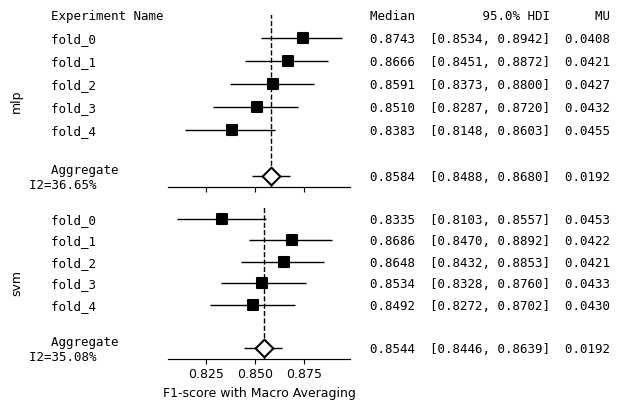

In [6]:
study.plot_forest_plot(metric="f1@macro");


The real question though, is this difference significant or not? How certain can we be that the MLP outperforms the SVM? For this, we can request comparisons between the experiment aggregates. Let's say that any difference smaller than $0.005$ is deemed practically equivalent (i.e., we assume that's a difference of 0).

In [7]:
print(
    study.report_pairwise_comparison(
        metric="f1@macro",
        experiment_a="mlp/aggregated",
        experiment_b="svm/aggregated",
        min_sig_diff=0.005,
    ),
)


Experiment mlp/aggregated's f1@macro being greater than svm/aggregated could be considered 'dubious'* (Median Δ=0.0041, 95.00% HDI=[-0.0100, 0.0171], p_direction=72.15%).

There is a 54.06% probability that this difference is bidirectionally significant (ROPE=[-0.0050, 0.0050], p_ROPE=45.94%).

Bidirectional significance could be considered 'undecided'*.

There is a 44.29% probability that this difference is significantly positive (p_pos=44.29%, p_neg=9.77%).

Relative to two random models (p_ROPE,random=60.21%) significance is 1.7807 times more likely.

* These interpretations are based off of loose guidelines, and should change according to the application.


/home/ioverho/Projects/prob_conf_mat/src/prob_conf_mat/study.py:1920: UserWarning: Parameter `plot_obs_point` is True, but one of the experiments has no observation (i.e. aggregated). As a result, no observed difference will be shown.
  warnings.warn(


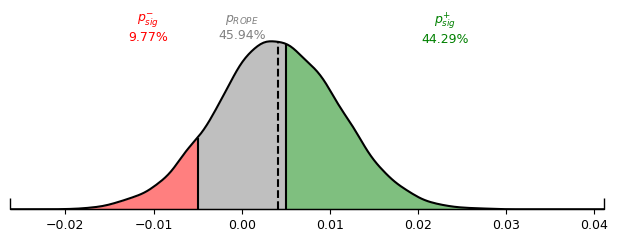

In [8]:
study.plot_pairwise_comparison(
    metric="f1@macro",
    experiment_a="mlp/aggregated",
    experiment_b="svm/aggregated",
    min_sig_diff=0.005,
);


Well, it turns out that the MLP is not really that much better. With the present amount of information, the probability of it being the better model is worse than a coin flip. To be sure of anything, we'll have to repeat the experiment with (much) more data.

## Saving the Study

Now let's say you wanted to share your analysis with a colleague. You could share all of the necessary files as a directory, or equivalently, you could just provide the study's configuration. We can access the configuration as a Python dict using the `.to_dict()` method.

In [9]:
from pprint import pprint

study_config = study.to_dict()

pprint(study_config, indent=2, width=100, depth=3, sort_dicts=False)


{ 'seed': 0,
  'num_samples': 10000,
  'ci_probability': 0.95,
  'experiments': { 'mlp': { 'fold_0': {...},
                            'fold_1': {...},
                            'fold_2': {...},
                            'fold_3': {...},
                            'fold_4': {...}},
                   'svm': { 'fold_0': {...},
                            'fold_1': {...},
                            'fold_2': {...},
                            'fold_3': {...},
                            'fold_4': {...}}},
  'metrics': { 'acc': {'aggregation': 'fe_gaussian'},
               'f1': {'aggregation': 'fe_gaussian'},
               'f1@weighted': {'aggregation': 'fe_gaussian'},
               'f1@macro': {'aggregation': 'fe_gaussian'},
               'mcc': {'aggregation': 'beta'}}}


This is a standard Python `dict`, and can be saved however you like (e.g., as a human readable YAML or TOML file, as a pickle object, as a JSON file, etc.). This can then be shared with others to replicate your work.

Specifically, we can recreate a study by using the `.from_dict` classmethod:

In [10]:
new_study = pcm.Study.from_dict(study_config)


The new study will be configured in the same way as before:

In [11]:
new_study.report_aggregated_metric_summaries(metric="f1@macro")


Group,Median,Mode,HDI,MU,Kurtosis,Skew,Var. Within,Var. Between,I2
mlp,0.8584,0.8578,"[0.8488, 0.8680]",0.0192,0.0050,0.0067,0.0001,0.0001,36.65%
svm,0.8544,0.8527,"[0.8446, 0.8639]",0.0192,0.0055,-0.0298,0.0001,0.0001,35.08%


Please note that the state of RNG is *not* saved. This means that generally speaking, the results will not be exactly the same. This is because the order in which experiments and metrics are added to the study, as well as the order in which report elements are generated will influence the RNG's state. In this case, the order in which different experiments and metrics were added, and which report elements we requested when is the same as before, the output is same as well.

In [12]:
report_1


Group,Median,Mode,HDI,MU,Kurtosis,Skew,Var. Within,Var. Between,I2
mlp,0.8584,0.8578,"[0.8488, 0.8680]",0.0192,0.0050,0.0067,0.0001,0.0001,36.65%
svm,0.8544,0.8527,"[0.8446, 0.8639]",0.0192,0.0055,-0.0298,0.0001,0.0001,35.08%


Generally, this will not be the same. However, with a large enough `num_samples` parameter, this should not affect the study's outcomes.


## Next Steps

This was the last tutorial. You should now be able to use `prob_conf_mat` with some confidence. The other documentation sections will help deepen you understanding of the library, when you're ready for it.

For more on IO:

* Check out the [reference documentation](https://ioverho.github.io/prob_conf_mat/Reference/IO.html) on implemented IO methods


For more advanced material:

* Check out the [how-to guide](https://ioverho.github.io/prob_conf_mat/How%20To%20Guides/extending_the_library.html) on extending the library with your own metrics or your own averaging, experiment aggregation, or IO methods
* Check out the [replication case-study](https://ioverho.github.io/prob_conf_mat/Explanation/totsch_replication.html) for some advanced use-cases and custom plots